### Case - [Pierre-Antoine Denarié]

### Housekeeping & Imports

In [1]:
# Clear all variables from the workspace
%reset -f

In [2]:
### Package Imports
# System
from __future__ import annotations
import os
from pathlib import Path
import re
import logging
from typing import Dict
from functools import partial
import time

# Data
import numpy as np
import pandas as pd

# sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

# Own packages
from src.myfunctions import *

# Import visualisation libraries
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from IPython.display import display
import seaborn as sns

# Pretty display for notebooks
%matplotlib inline

# Setup Logging
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")


INFO: Pandas backend loaded 2.3.1
INFO: Numpy backend loaded 2.1.3
INFO: Pyspark backend NOT loaded
INFO: Python backend loaded


In [3]:
# Parameter
DATA_DIR = "Data"
DATA_RAW_DIR = DATA_DIR + "/Raw"
PROCESSED_DIR = DATA_DIR + "/Processed"

REPORTS : str = "Reports"
PROFILING : str = REPORTS + "/Profiling"

### Data Loading

In [4]:
# Clean Data imports
dfs = load_csv_folder(DATA_RAW_DIR)
print(dfs.keys())

INFO: Loaded bus_trips from bus_trips.csv | shape=(591766, 11)
INFO: Loaded check_ins from check_ins.csv | shape=(41923, 2)
INFO: Loaded stops from stops.csv | shape=(5636, 3)


dict_keys(['bus_trips', 'check_ins', 'stops'])


### Data exploration

Use Ydata to profile data, get high-level insights

In [5]:
# Generate profling reports
df_profiles = generate_profiling_reports(dfs, title="Data Profiling Report")

# View profiling reports
display_profiling_reports_web(profiles=df_profiles)

# DProcess & display time series data
pipeline = {
    "check_ins": [
        Step("add_feature", when=has_cols("id"), fn=partial(add_feature, src="id", dest='id_Datetime', function=parse_time_column))
    ]
}

dfs_processed = run_pipeline(dfs, pipeline)
display_profiling_reports_web(generate_profiling_reports(dfs_processed, title="Data Profiling Processed Report", timeseries=True, sortby="id_Datetime"), refresh_results=False)

INFO: Generated profiling report for bus_trips
INFO: Generated profiling report for check_ins
INFO: Generated profiling report for stops
INFO: Opened profiling report for bus_trips
INFO: Opened profiling report for check_ins
INFO: Opened profiling report for stops
INFO: ▶ bus_trips: 0 steps
INFO: ▶ check_ins: 1 steps
INFO:   - add_feature: (41923, 2) -> (41923, 3) (569 ms)
INFO: ▶ stops: 0 steps
ERROR: Error generating profiling report for bus_trips: 'id_Datetime'
INFO: Generated profiling report for check_ins
ERROR: Error generating profiling report for stops: 'id_Datetime'
INFO: Opened profiling report for check_ins


Profiling report shows duplicates in bus trips. explore Duplicates

<Axes: title={'center': 'Duplicate Count per Row in bus_trips'}, xlabel='duplicate_count'>

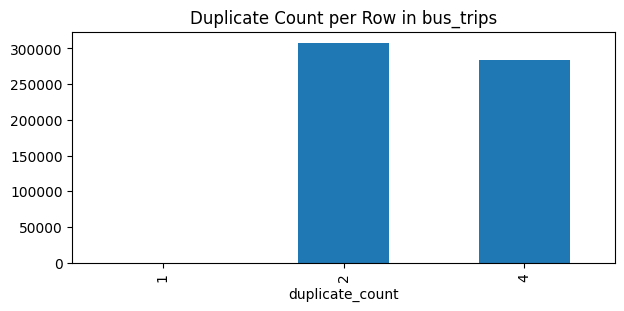

In [6]:
duplicate_count_per_row(df=dfs['bus_trips'], return_series=False)['duplicate_count'].value_counts().sort_index().plot(kind='bar', figsize=(7, 3), title="Duplicate Count per Row in bus_trips")


--> need duplicate removal in the Pipeline.

outliers: lets visualize any outliers there might be present in teh data. Based on wen busses are stuck, an accident happens, or else.

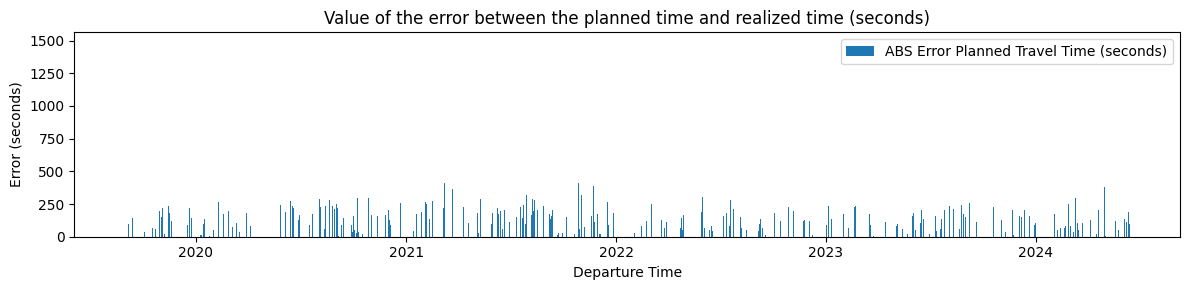

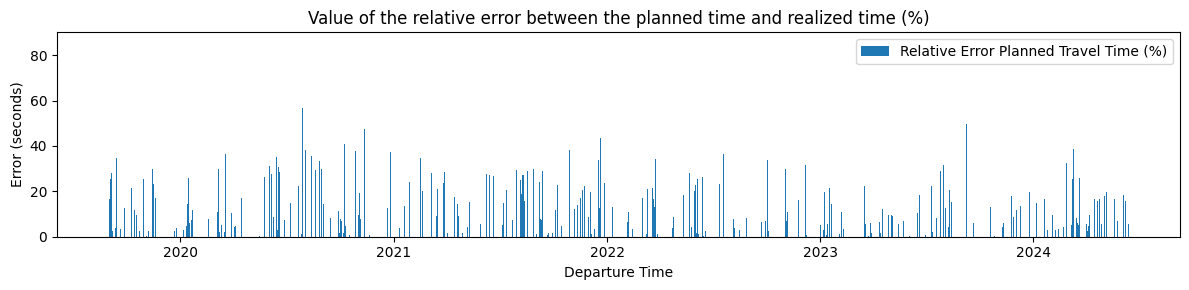

In [7]:
y_planned_timedelta = add_time_delta(df=dfs['bus_trips'], real_time='realized_time', plan_time='planned_time', return_series=False)
add_total_seconds(y_planned_timedelta,time_cols=['planned_time'])   # type: ignore
y_planned_timedelta['relative delta'] = y_planned_timedelta['time_delta'] / y_planned_timedelta['planned_time_quant'].abs()*100


N_plotsteps = 1000      # keep above 1000 for performance

plt.figure(figsize=(12, 3))
plt.bar(pd.to_datetime(dfs['bus_trips']['departure_time']).iloc[::N_plotsteps], abs(y_planned_timedelta['time_delta'].iloc[::N_plotsteps]), label='ABS Error Planned Travel Time (seconds)')
plt.xlabel('Departure Time')
plt.ylabel('Error (seconds)')
plt.title('Value of the error between the planned time and realized time (seconds)')
plt.legend()
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 3))
plt.bar(pd.to_datetime(dfs['bus_trips']['departure_time']).iloc[::N_plotsteps], abs(y_planned_timedelta['relative delta'].iloc[::N_plotsteps]), label='Relative Error Planned Travel Time (%)')
plt.xlabel('Departure Time')
plt.ylabel('Error (seconds)')
plt.title('Value of the relative error between the planned time and realized time (%)')
plt.legend()
plt.tight_layout()
plt.show()



From the plots we can see that the data contains serious outliers. Although realistic, we do not want to train the model on these outliers as we cannot incorporate the factors in it. Furthermore, we want the estimates to be in the ideal state.

We will drop the datapoints which have a relative error above a certain threshold.

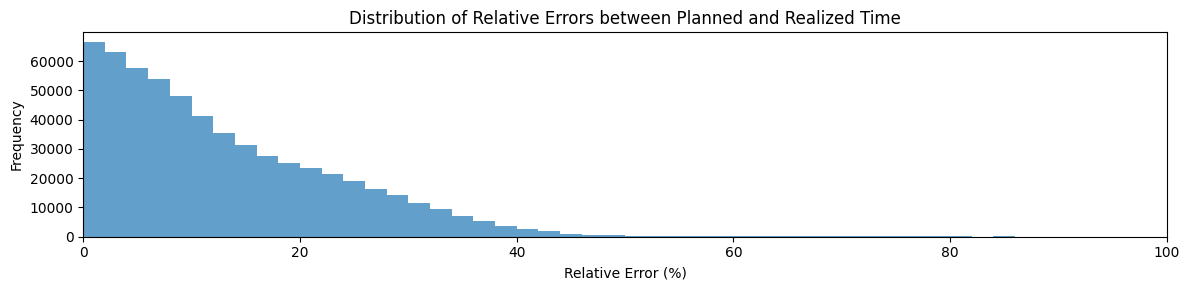

In [8]:
# clear out NaN values
rel_error_lim = 100

rel_delta = abs(y_planned_timedelta['relative delta'].dropna())
rel_delta_clean = rel_delta[np.isfinite(rel_delta) & (rel_delta <= rel_error_lim)]


# Plot distribution of relative errors
plt.figure(figsize=(12, 3))
plt.hist(rel_delta_clean, bins=50, alpha=0.7)
plt.xlabel('Relative Error (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Errors between Planned and Realized Time')
plt.xlim(0, rel_error_lim)
plt.tight_layout()
plt.show()

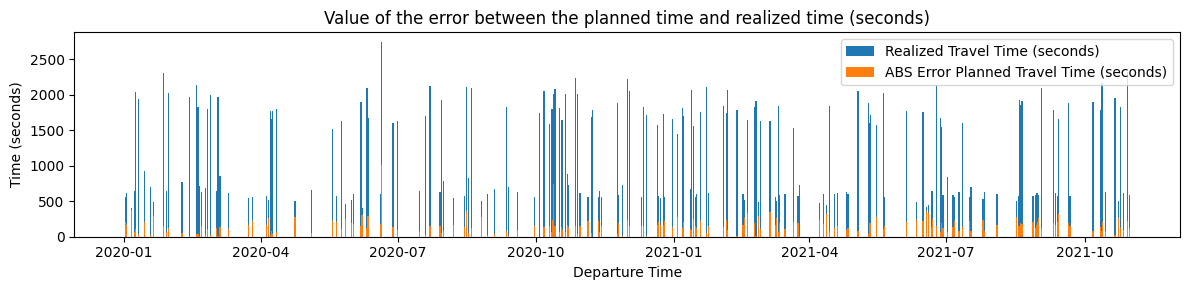

In [9]:
# plot results during covid only
N_plotsteps = 1000
dfs_covid = dfs['bus_trips'].copy()
dfs_covid['time_delta'] = y_planned_timedelta['time_delta']
dfs_covid = data_cutoff_dates(dfs_covid, col_datetime='operatingday', start_date='2020-01-01', end_date='2021-10-31')
dfs_postcovid = dfs['bus_trips'].copy()
dfs_postcovid['time_delta'] = y_planned_timedelta['time_delta']
dfs_postcovid = data_cutoff_dates(dfs_postcovid, col_datetime='operatingday', start_date='2021-11-01', end_date='2030-01-01')

plt.figure(figsize=(12, 3))
plt.bar(pd.to_datetime(dfs_covid['departure_time']).iloc[::N_plotsteps], pd.to_timedelta(dfs_covid['realized_time']).dt.total_seconds().iloc[::N_plotsteps], label='Realized Travel Time (seconds)')
plt.bar(pd.to_datetime(dfs_covid['departure_time']).iloc[::N_plotsteps], abs(dfs_covid['time_delta'].iloc[::N_plotsteps]), label='ABS Error Planned Travel Time (seconds)')
plt.xlabel('Departure Time')
plt.ylabel('Time (seconds)')
plt.title('Value of the error between the planned time and realized time (seconds)')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Compare covid with post covids statistics
covid_comp = pd.DataFrame()
covid_comp['covid realized'] = pd.to_timedelta(dfs_covid['realized_time']).dt.total_seconds().describe()
covid_comp['post_covid realized'] = pd.to_timedelta(dfs_postcovid['realized_time']).dt.total_seconds().describe()
covid_comp['covid planned'] = pd.to_timedelta(dfs_covid['planned_time']).dt.total_seconds().describe()
covid_comp['post_covid planned'] = pd.to_timedelta(dfs_postcovid['planned_time']).dt.total_seconds().describe()
covid_comp['covid delta abs'] = abs(dfs_covid['time_delta']).describe()
covid_comp['post_covid delta abs'] = abs(dfs_postcovid['time_delta']).describe()


# Ensure departure_time is datetime
dfs_covid['departure_date'] = pd.to_datetime(dfs_covid['departure_time']).dt.date
dfs_postcovid['departure_date'] = pd.to_datetime(dfs_postcovid['departure_time']).dt.date

# Count trips per day
trips_per_day = dfs_covid.groupby('departure_date').size()
trips_per_day_post = dfs_postcovid.groupby('departure_date').size()

# Compute average
avg_trips_per_day = trips_per_day.mean()
avg_trips_per_day_post = trips_per_day_post.mean()
print("Average number of trips per day (covid period):", avg_trips_per_day)
print("Average number of trips per day (post-covid period):", avg_trips_per_day_post)

Average number of trips per day (covid period): 326.55007473841556
Average number of trips per day (post-covid period): 346.9498956158664


In [11]:
# take the count, mean, std rows of covid_comp & divide by the mean number_of_checkis of the covid period from table ceckins
dfs_checkins = dfs['check_ins'].copy()
dfs_checkins['parsed_date'] = parse_time_column(dfs['check_ins']['id'])

dfs_checkin_covid = data_cutoff_dates(dfs_checkins.copy(), col_datetime='parsed_date', start_date='2020-01-01', end_date='2021-10-31')
dfs_checkin_postcovid = data_cutoff_dates(dfs_checkins.copy(), col_datetime='parsed_date', start_date='2021-11-01', end_date='2030-01-01')

# compare statistics
covid_checkins_comp = pd.DataFrame()
covid_checkins_comp['covid checkins'] = dfs_checkin_covid['number_of_check_ins'].describe()
covid_checkins_comp['post_covid checkins'] = dfs_checkin_postcovid['number_of_check_ins'].describe()

In [12]:
cols_covid = ['covid delta abs','post_covid delta abs']
final_covid_comp = covid_checkins_comp.copy()
final_covid_comp['covid delta abs'] = covid_comp['covid delta abs']
final_covid_comp['post_covid delta abs'] = covid_comp['post_covid delta abs']
final_covid_comp['covid: bus times / checkins'] = covid_comp['covid delta abs'] / final_covid_comp['covid checkins']
final_covid_comp['post_covid: bus times / checkins'] = covid_comp['post_covid delta abs'] / final_covid_comp['post_covid checkins']

final_covid_comp

,covid checkins,post_covid checkins,covid delta abs,post_covid delta abs,covid: bus times / checkins,post_covid: bus times / checkins
count,16055.0,25845.0,218462.000000,332378.000000,13.607101,12.860437
mean,75.209885,121.35025,151.374024,129.572282,2.012688,1.067755
std,82.029834,106.559766,137.643681,102.794287,1.677971,0.964663
min,0.0,0.2,0.000000,0.000000,NaN,0.0
25%,10.9,18.9,67.000000,63.000000,6.146789,3.333333
50%,54.0,100.0,136.000000,118.000000,2.518519,1.18
75%,110.4,190.9,205.000000,178.000000,1.856884,0.932425
max,622.1,534.2,3623.000000,3851.000000,5.823823,7.208911


---------------

### Data Cleaning & Preprocessing

### Important findings:
- only 3 relevant stops: 2 for line 1, 2 for line 2, 1 shared stop.
    - line column + direction information encoded in 2 features
    - most of stop data irrelevant

- Date constraints:
    - Checkin data has   Minimum:   2020-01-01 00:00:00  &   Maximum:   2024-10-12 23:00:00
    - bus_trip data has  Minimum:	2019-08-27 10:12:40  &   Maximum:	2024-06-18 23:45:39
    - --> data time constraints: [01-01-2020 & 2024-06-18]

- periodicity in data:
    -  both bus_trips & check_ins show high level of periodicity (daily, weekly, monthly, yearly)

### Preprocessing (high level steps)

In [13]:
# Clean Data imports
dfs = load_csv_folder(DATA_RAW_DIR)
print(dfs.keys())

INFO: Loaded bus_trips from bus_trips.csv | shape=(591766, 11)
INFO: Loaded check_ins from check_ins.csv | shape=(41923, 2)
INFO: Loaded stops from stops.csv | shape=(5636, 3)


dict_keys(['bus_trips', 'check_ins', 'stops'])


In [14]:
# PreProcessing Pipeline
steps_preproc_bus_trips = [
    Step("convert columns to datetime", fn=partial(convert_columns_by_type, columns=["departure_time", "realized_time", "planned_time"],
                                                   type_dict={"departure_time": "datetime", 
                                                               "realized_time": "timedelta", 
                                                               "planned_time": "timedelta"},
                                                   formats={"departure_time": "%Y-%m-%d %H:%M:%S", 
                                                            "realized_time": "%H:%M:%S", 
                                                            "planned_time": "%H:%M:%S"})),
    Step("drop duplicate values", fn=partial(drop_duplicates)),                                     # type: ignore
    Step("Make categorical", fn=partial(make_categorical, cols=['lineplanningnumber']))             # type: ignore
]

steps_preproc_stops = []

steps_preproc_check_ins = [
    Step("Parse time", when=has_cols("id"), fn=partial(add_feature, src="id", dest='id_Datetime', function=parse_time_column)),
    Step("multiply checkins x1000", fn=partial(multiply_checkins, column="number_of_check_ins", factor=1000))
]

pipeline_preprocess = {
    "bus_trips": steps_preproc_bus_trips,
    "stops": steps_preproc_stops,
    "check_ins": steps_preproc_check_ins
}

dfs_preprocessed = run_pipeline(dfs, pipeline_preprocess)

# Merge dataframes
dfs_preprocessed['merged_bustrip_and_checkins'] = attach_weighted_checkins_fast(
                                                    dfs_preprocessed['bus_trips'], 
                                                    dfs_preprocessed['check_ins'],
                                                    trip_start_col="departure_time",
                                                    trip_duration_col="realized_time",
                                                    checkin_time_col="id_Datetime",
                                                    checkin_value_col="number_of_check_ins",
                                                    out_col="checkins_weighted")

dfs_preprocessed['merged_stops_start'] = pd.merge(dfs_preprocessed['merged_bustrip_and_checkins'], dfs_preprocessed['stops'].rename(columns=lambda x: x + '_start' if x != 'key_column' else x),
                                    left_on='userstopcode_start', right_on='userstopcode_start', suffixes=('', '_start'))

dfs_preprocessed['merged'] = pd.merge(dfs_preprocessed['merged_stops_start'], dfs_preprocessed['stops'].rename(columns=lambda x: x + '_end' if x != 'key_column' else x),
                                    left_on='userstopcode_end', right_on='userstopcode_end', suffixes=('', '_end'))


# Add feature Pipeline
steps_features = [
    Step("add feature: total seconds", when=is_timedelta_column(["realized_time","planned_time"]),                                  # type: ignore
         fn=partial(add_total_seconds, time_cols=["realized_time","planned_time"])),                                                # type: ignore
    Step("add feature: time delta", when=is_timedelta_column(["realized_time","planned_time"]),                                     # type: ignore
         fn=partial(add_time_delta, real_time="realized_time", plan_time="planned_time")),                                          # type: ignore
    Step("add feature: directional columns", when = None,                                                                           # type: ignore
         fn=partial(add_direction_columns, col_start="stopname_start", col_stop="stopname_end", col_line="lineplanningnumber")),    # type: ignore
    Step("add feature: cycilical time", when = None,                                                                                # type: ignore
         fn=partial(add_time_cyclical, ts_col="departure_time")),                                                                   # type: ignore
    Step("add feature: time fourier", when = None,                                                                                  # type: ignore
         fn=partial(add_bus_time_fourier, time_col="departure_time")),                                                              # type: ignore               
    Step("add feature: lag & rolling values", when = None,                                                                          # type: ignore
         fn=partial(add_lags_rolls_with_reliability, time_series_col="departure_time",
                    y_col_name='realized_time', group_col='line_key',lags=(1, 24, 168))), 
]

pipeline_features = {
    "merged": steps_features
}

dfs_feature_set = run_pipeline(dfs_preprocessed, pipeline_features, feature_col=True)         

# Cuttoff dates & remove outliers based on new features
steps_cutoff = [
    Step("Remove outliers", fn=partial(drop_rows_by_percentage, percentage=0.3, col_x='time_delta', col_y='realized_time_quant')),  # type: ignore
    Step("cutoff dates", when=None, 
         fn=partial(data_cutoff_dates, col_datetime="operatingday", start_date='2020-01-01', end_date='2024-06-18')),               # type: ignore
]

pipeline_cutoff = {
    "merged": steps_cutoff
}

dfs_final_set = run_pipeline(dfs_feature_set, pipeline_cutoff, feature_col=False)

INFO: ▶ bus_trips: 3 steps


INFO:   - convert columns to datetime: (591766, 11) -> (591766, 11) (1927 ms)
INFO:   - drop duplicate values: (591766, 11) -> (224972, 11) (428 ms)
INFO:   - Make categorical: (224972, 11) -> (224972, 11) (15 ms)
INFO: ▶ check_ins: 2 steps
INFO:   - Parse time: (41923, 2) -> (41923, 3) (150 ms)
INFO:   - multiply checkins x1000: (41923, 3) -> (41923, 3) (0 ms)
INFO: ▶ stops: 0 steps
INFO: Attached 'checkins_weighted' (vectorized, DST-safe). Coverage median=1.00, mean=0.93. NaNs in checkins_weighted: 15883/224972 (7.1%).
INFO: ▶ bus_trips: 0 steps
INFO: ▶ check_ins: 0 steps
INFO: ▶ stops: 0 steps
INFO: ▶ merged_bustrip_and_checkins: 0 steps
INFO: ▶ merged_stops_start: 0 steps
INFO: ▶ merged: 6 steps
INFO:   - add feature: total seconds: (224972, 17) -> (224972, 19) (0 ms)
INFO:   - add feature: time delta: (224972, 19) -> (224972, 20) (15 ms)
INFO:   - add feature: directional columns: (224972, 20) -> (224972, 22) (185 ms)
INFO:   - add feature: cycilical time: (224972, 22) -> (224972,

INFO: Omitting column 'ind_miss_lag1' (all values below threshold 0.15)
INFO: Omitting column 'ind_miss_lag24' (all values below threshold 0.15)
INFO: Omitting column 'ind_miss_lag168' (all values below threshold 0.15)
INFO: Omitting column 'ind_warmup' (all values below threshold 0.15)


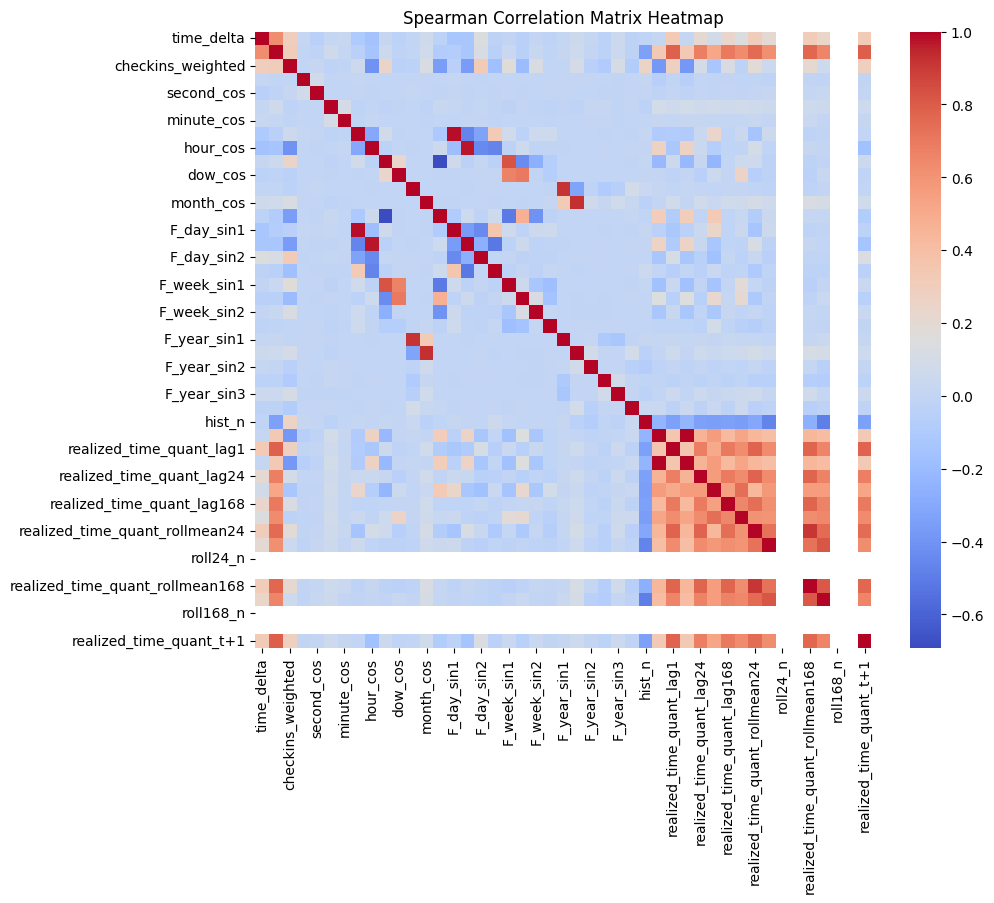

In [15]:
# Plot correlation matrix
corr_columns = ['time_delta','realized_time_quant','checkins_weighted','second_sin','second_cos', 'minute_sin', 'minute_cos', 'hour_sin', 'hour_cos',
        'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'is_weekend',
        'F_day_sin1', 'F_day_cos1', 'F_day_sin2', 'F_day_cos2', 'F_week_sin1',
        'F_week_cos1', 'F_week_sin2', 'F_week_cos2', 'F_year_sin1',
        'F_year_cos1', 'F_year_sin2', 'F_year_cos2', 'F_year_sin3',
        'F_year_cos3','hist_n', 'age_since_prev_h','realized_time_quant_lag1',
        'ind_miss_lag1', 'lag1_age_h', 'realized_time_quant_lag24',
        'ind_miss_lag24', 'lag24_age_h', 'realized_time_quant_lag168',
        'ind_miss_lag168', 'lag168_age_h', 'realized_time_quant_rollmean24',
        'realized_time_quant_rollstd24', 'roll24_n', 'roll24_cov',
        'realized_time_quant_rollmean168', 'realized_time_quant_rollstd168',
        'roll168_n', 'roll168_cov', 'ind_warmup', 'realized_time_quant_t+1'
]

plot_corr_heatmap(
    dfs_final_set['merged'],
    method='spearman',
    min_value_threshold=0.15,
    annot=False,
    y_axis_columns=corr_columns,
    columns=corr_columns
)


--------------------

### ML Pipeline

In [16]:
TARGET = "realized_time_quant"            
TIMESTAMP_COL = "operatingday"         


RAW_NUMERIC_COLS = [
        'planned_time_quant', 'checkins_weighted',
        'second_sin','second_cos', 'minute_sin', 'minute_cos', 'hour_sin', 'hour_cos',
        'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'is_weekend',
        'F_day_sin1', 'F_day_cos1', 'F_day_sin2', 'F_day_cos2', 'F_week_sin1',
        'F_week_cos1', 'F_week_sin2', 'F_week_cos2', 'F_year_sin1',
        'F_year_cos1', 'F_year_sin2', 'F_year_cos2', 'F_year_sin3',
        'F_year_cos3','hist_n', 'age_since_prev_h','realized_time_quant_lag1',
        'ind_miss_lag1', 'lag1_age_h', 'realized_time_quant_lag24',
        'ind_miss_lag24', 'lag24_age_h', 'realized_time_quant_lag168',
        'ind_miss_lag168', 'lag168_age_h', 'realized_time_quant_rollmean24',
        'realized_time_quant_rollstd24', 'roll24_n', 'roll24_cov',
        'realized_time_quant_rollmean168', 'realized_time_quant_rollstd168',
        'roll168_n', 'roll168_cov', 'ind_warmup', 'realized_time_quant_t+1'
]
RAW_CATEGORICAL_COLS = [
    'lineplanningnumber', 'direction','line_key'
]

REQUIRED_RAW_FEATURES = RAW_NUMERIC_COLS + RAW_CATEGORICAL_COLS

In [17]:
# Tree model preprocessor: trees don’t need scaling
numeric_tree = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median", add_indicator=True)),
])

categorical_common = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=None, sparse_output=False)),
])

preprocess_for_trees = ColumnTransformer(
    transformers=[
        ("num", numeric_tree, RAW_NUMERIC_COLS),
        ("cat", categorical_common, RAW_CATEGORICAL_COLS),
    ],
    remainder="drop",
)

In [18]:
gb_model = HistGradientBoostingRegressor(
    max_iter=500,
    learning_rate=0.05,
    max_depth=None,        # let leaves control complexity
    max_leaf_nodes=31,
    l2_regularization=0.0,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=1,          
)

gb_pipeline = Pipeline([
    ("prep", preprocess_for_trees),
    ("model", gb_model)],
    verbose=True)


In [19]:
# Train on your chosen train window
cutoff_test_date = "2024-01-01"
df_train = data_cutoff_dates(dfs_final_set['merged'], col_datetime=TIMESTAMP_COL, start_date='2020-01-01', end_date=cutoff_test_date)
X_train = df_train[REQUIRED_RAW_FEATURES]
y_train = df_train[TARGET]

fit_with_status(gb_pipeline,   X_train, y_train, "HGBR")


[HGBR] fitting on 186671 rows / 51 features…
[Pipeline] .............. (step 1 of 2) Processing prep, total=   2.1s
Binning 0.079 GB of training data: 0.600 s
Binning 0.009 GB of validation data: 0.016 s
Fitting gradient boosted rounds:
Fit 500 trees in 24.147 s, (15500 total leaves)
Time spent computing histograms: 12.700s
Time spent finding best splits:  2.509s
Time spent applying splits:      1.755s
Time spent predicting:           0.290s
[Pipeline] ............. (step 2 of 2) Processing model, total=  24.2s
[HGBR] done in 26.30s


In [20]:
# Predict on future (same required columns)
df_future = data_cutoff_dates(dfs_final_set['merged'], col_datetime=TIMESTAMP_COL, start_date=cutoff_test_date, end_date='2030-01-01')
X_future = df_future[REQUIRED_RAW_FEATURES]
y_future = df_future[TARGET]  # Optional: if you have future labels for evaluation

y_pred_gb  = predict_with_status(gb_pipeline,   X_future, "HGBR")


[HGBR] predicting 21499 rows…
[HGBR] done in 1.17s


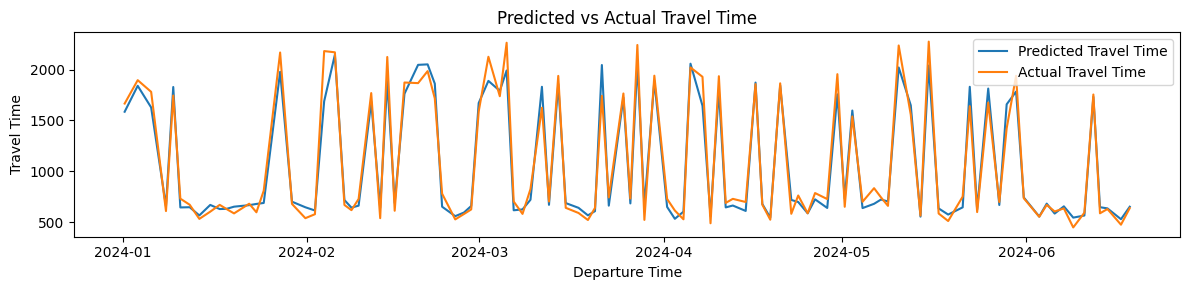

In [21]:
N = 200
df_predict = df_future.copy()
df_predict['y_est'] = y_pred_gb
df_predict = df_predict.sort_values('departure_time').iloc[::N]

plt.figure(figsize=(12, 3))
plt.plot(df_predict['departure_time'], df_predict['y_est'], label='Predicted Travel Time')
plt.plot(df_predict['departure_time'], df_predict['realized_time_quant'], label='Actual Travel Time')
plt.xlabel('Departure Time')
plt.ylabel('Travel Time')
plt.title('Predicted vs Actual Travel Time')
plt.legend()
plt.tight_layout()
plt.show()

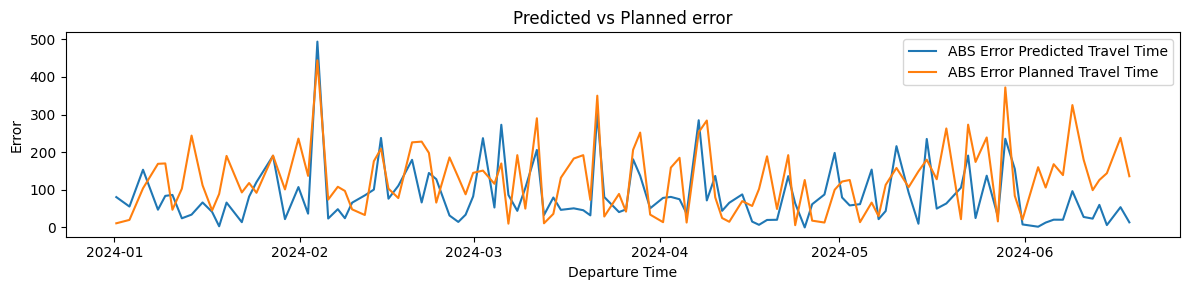

In [22]:
# compare to previous planned values
df_predict['delta_predict'] = df_predict['realized_time_quant'] - df_predict['y_est']

plt.figure(figsize=(12, 3))
plt.plot(df_predict['departure_time'], abs(df_predict['delta_predict']), label='ABS Error Predicted Travel Time')
plt.plot(df_predict['departure_time'], abs(df_predict['time_delta']), label='ABS Error Planned Travel Time')
plt.xlabel('Departure Time')
plt.ylabel('Error')
plt.title('Predicted vs Planned error')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# summarize score metrics
df_eval = df_future.copy()
df_eval["y_true"] = df_future["realized_time_quant"]
df_eval["y_gb"]   = y_pred_gb
df_eval["baseline_plan"] = df_future["planned_time_quant"]/60  # if target is delta; otherwise planned_time_min

scores = summarize_errors(
    df_eval, y_col="y_true", yhat_col="y_gb",
    baseline_col="planned_time_quant",                 
    group_cols=["lineplanningnumber","direction"],           
    duration_col="realized_time_quant",             
)
print(pd.Series(scores).round(3))


MAE_min                      1.173
RMSE_min                     1.671
MedianAE_min                 0.856
Bias_ME_min                 -0.276
P90_|e|_min                  2.507
Within_±1min                 0.565
Within_±2min                 0.837
MASE_vs_baseline             0.615
MAE_duration_weighted_min    1.427
MAE_macro_groups_min         1.303
dtype: float64


---------

In [ ]:
# Optimize model parameters using a gridsearch method
tscv = TimeSeriesSplit(n_splits=5)
sc_mae = make_scorer(mean_absolute_error, greater_is_better=False)

search = GridSearchCV(
    estimator=gb_pipeline,                        
    param_grid={"model__max_leaf_nodes":[15,31,63],
                "model__learning_rate":[0.03, 0.05]},
    scoring=sc_mae,                               
    cv=tscv,
    verbose=2,
    n_jobs=-1,
)
search.fit(X_train, y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [ ]:
# Use the best estimator to predict
y_pred_best = search.best_estimator_.predict(X_future)

# If you want to see the best parameters:
print("Best parameters:", search.best_params_)

# suppose you predicted minutes of delay (delta_min)
df_eval_best = df_future.copy()
df_eval_best["y_true"] = df_future["realized_time_quant"]
df_eval_best["y_gb"]   = y_pred_best
df_eval_best["baseline_plan"] = df_future["planned_time_quant"]/60

scores = summarize_errors(
    df_eval_best, y_col="y_true", yhat_col="y_gb",
    baseline_col="planned_time_quant",
    group_cols=["lineplanningnumber", "direction"],
    duration_col="realized_time_quant",
)
print(pd.Series(scores).round(3))

Best parameters: {'model__learning_rate': 0.03, 'model__max_leaf_nodes': 31}
MAE_min                      1.173
RMSE_min                     1.665
MedianAE_min                 0.860
Bias_ME_min                 -0.252
P90_|e|_min                  2.513
Within_±1min                 0.562
Within_±2min                 0.837
MASE_vs_baseline             0.615
MAE_duration_weighted_min    1.421
MAE_macro_groups_min         1.299
dtype: float64
